# Information

In this notebook we will computationally determine the area of the Mandelbrot set. 

**NOTE: This notebook was used to generate large datasets for the figures that we use in the report. These were generated by using different global constants and took 3+ hours to compute. This notebook defines some computationally smaller constants, so the notebook can still be run in a reasonable amound of time. The large datasets have been saved in .npy files and can be loaded in by uncommenting a block of code later in the file, which overwrites the data generated in the notebook. This way, the plots used in the report can be reproduced exactly.

ALL IMPORTS HERE:

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import colorsys
from scipy.stats import norm
import matplotlib.patches as patches

ALL GLOBAL CONSTANTS HERE:

In [165]:
# Default ranges which we will test samples in
STANDARD_REAL_MIN = -2
STANDARD_REAL_MAX = 1
STANDARD_IMAGINARY_MIN = -1.5
STANDARD_IMAGINARY_MAX = 1.5
# Default ranges of samples and iterations we will perform simulations for
STANDARD_NUM_SAMPLES_MIN = 500
STANDARD_NUM_SAMPLES_MAX = 5000
STANDARD_NUM_SAMPLES_STEPS = 25
STANDARD_NUM_ITERATIONS_MIN = 50
STANDARD_NUM_ITERATIONS_MAX = 1000
STANDARD_NUM_ITERATIONS_STEPS = 15
# The amount of runs we execute for all simulations to calculate the variance
STANDARD_NUM_RUNS = 25
# The default number of iterations after which a point is regarded to be in the Mandelbrot set
STANDARD_MAX_ITERATIONS = 1000

In [166]:
class ComplexRange:
    """Datatype that stores an interval of complex numbers."""

    def __init__(
        self,
        real_min: float = STANDARD_REAL_MIN,
        real_max: float = STANDARD_REAL_MAX,
        imaginary_min: float = STANDARD_IMAGINARY_MIN,
        imaginary_max: float = STANDARD_IMAGINARY_MAX,
    ):
        self.real_min = real_min
        self.real_max = real_max
        self.imaginary_min = imaginary_min
        self.imaginary_max = imaginary_max

        self.real_range_size = self.real_max - self.real_min
        self.imaginary_range_size = self.imaginary_max - self.imaginary_min

        self.domain_area = (self.real_max - self.real_min) * (self.imaginary_max - self.imaginary_min)

### (i) Visualizing the Mandelbrot set

In [167]:
def mandelbrot_sequence(
    complex_number: complex, max_iteration: int = STANDARD_MAX_ITERATIONS
) -> int:
    """Iterates a complex number with the Mandelbrot map z_{n+1} = z_n^2 + c
    for at most max_iterations iterations.

    Args:
        complex_number: The number being tested whether it is in the Mandelbrot set.
        max_iteration: The maximum amount of iterations for which the function will check a point.

    Returns:
        The last iteration counter if the complex number diverges else max_iteration.
    """
    z = 0
    counter = 0

    # The point diverges if it is ever greater than 2
    while np.abs(z) <= 2 and counter < max_iteration:
        counter += 1
        z = z**2 + complex_number
    return counter


def mandelbrot_diverges(
    complex_numbers: np.ndarray[complex], max_iteration: int = STANDARD_MAX_ITERATIONS
) -> np.ndarray[bool]:
    """Does the same thing as mandelbrot_sequence, but performs it for an array of values.
    This function is faster, but does not return info about how fast a point diverges.

    Args:
        complex_numbers: The numbers being tested whether they are in the Mandelbrot set.
        max_iteration: The maximum amount of iterations for which the function will check a point.

    Returns:
        Boolean array where True indicates that the corresponding point diverges.
    """
    z = np.zeros(complex_numbers.shape, dtype=np.complex128)

    diverged = np.zeros(complex_numbers.shape, dtype=bool)

    for _ in range(max_iteration):
        # Mandelbrot iterate points that haven't diverged yet
        z[~diverged] = z[~diverged] ** 2 + complex_numbers[~diverged]

        # Check for divergence and update the diverged array
        diverged |= np.abs(z) > 2

        # Stop if all points have diverged
        if np.all(diverged):
            break

    return diverged

### Plotting the Mandelbrot fractal with a colour gradient following a powerlaw. [Inspired by source.]

Computing Mandelbrot: 100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]


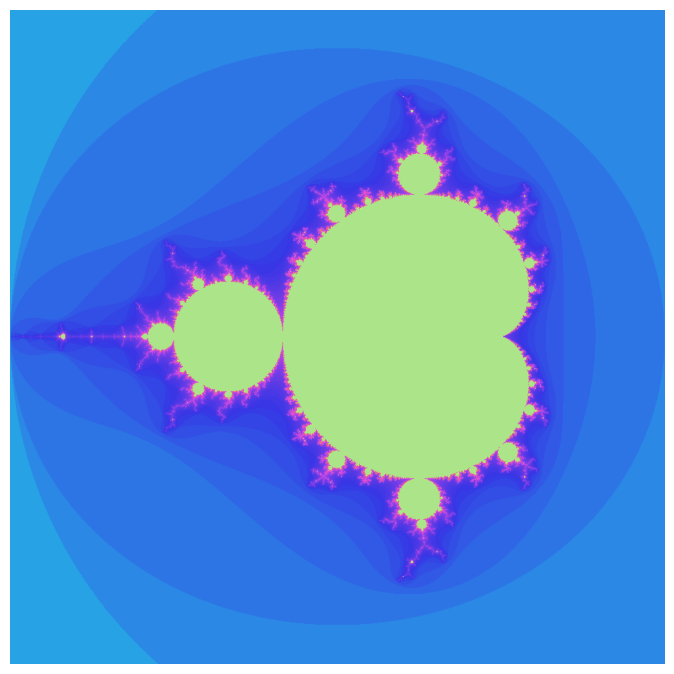

In [168]:
def power_color(
    distance: float, exp: float = 0.2, const: float = 0.27, scale: float = 1.0
) -> tuple[int]:
    """Map a normalized distance value to an RGB color using HSV color space.
    Inspired by https://medium.com/swlh/visualizing-the-mandelbrot-set-using-python-50-lines-f6aa5a05cf0f.

    Args:
        distance: Normalized distance (0 to 1).
        exp: Exponent to adjust the color scaling.
        const: Hue offset constant.
        scale: Hue scaling factor.

    Returns:
        tuple: RGB color tuple in the range 0-255.
    """
    color = distance**exp
    rgb = colorsys.hsv_to_rgb(const + scale * color, 1 - 0.6 * color, 0.9)
    return tuple(int(i * 255) for i in rgb)


def plot_mandelbrot_fractal(
    complex_range: ComplexRange,
    width: int,
    height: int,
    max_iterations: int = STANDARD_MAX_ITERATIONS,
) -> None:
    """Generate and plot a Mandelbrot fractal, where the rate of divergence
    is indicated using a colour scaling law.

    Args:
        complex_range: Range of complex numbers to plot the image for.
        width: Width of the image in pixels.
        height: Height of the image in pixels.
        max_iterations: Maximum number of iterations to iterate a point for.
    """
    real_range = np.linspace(complex_range.real_min, complex_range.real_max, width)
    imaginary_range = np.linspace(complex_range.imaginary_min, complex_range.imaginary_max, height)

    # Create an empty array to store RGB values
    fractal_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Compute the fractal
    for real_idx, real in enumerate(tqdm.tqdm(real_range, desc="Computing Mandelbrot")):
        for imaginary_idx, imaginary in enumerate(imaginary_range):
            complex_number = complex(real, imaginary)
            last_iteration_number = mandelbrot_sequence(complex_number, max_iterations)
            # map the number of iterations to a value between 0 and 1
            distance = (last_iteration_number + 1) / (max_iterations + 1)

            fractal_image[imaginary_idx, real_idx] = power_color(distance)

    # Show the image without axes or margins
    plt.figure(figsize=(10, 8.5), frameon=False)
    plt.imshow(
        fractal_image,
       extent=[
            complex_range.real_min,
            complex_range.real_max,
            complex_range.imaginary_min,
            complex_range.imaginary_max,
        ], 
    )
    plt.axis("off")
    plt.show()
    


plot_mandelbrot_fractal(ComplexRange(), 1000, 850)

### (ii) Finding the area using Monte-Carlo:

In [169]:
def mandelbrot_area(
    complex_numbers: np.ndarray[complex], num_iteration: int, domain_area: float
) -> float:
    """Calculates the area of the Mandelbrot set by iterating a set of complex numbers a certain
    amount of times and calculating the amount of the numbers that diverge compared to the total
    number of points tested.

    Args:
        complex_numbers: The numbers being tested whether they are in the Mandelbrot set.
        num_iteration: Number of iterations to be executed on every complex number.
        domain_area: Area of the box where the points in complex_values are sampled from.

    Returns:
        The estimated area of the Mandelbrot set.
    """
    diverged = mandelbrot_diverges(complex_numbers, num_iteration)
    # The amount of points that belong to the Mandelbrot set
    number_bounded_points = np.count_nonzero(~diverged)

    mandelbrot_area = domain_area * number_bounded_points / np.shape(complex_numbers)[0]

    return mandelbrot_area

In [170]:
def mandelbrot_area_RS(
    complex_range: ComplexRange,
    num_samples: np.ndarray[int],
    num_iterations: np.ndarray[int],
    runs: int = STANDARD_NUM_RUNS,
) -> np.ndarray[float]:
    """Calculates the area of the Mandelbrot set using Monte Carlo integration and random sampling.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        num_samples: The list of number of samples for which an area simulation will be done for.
        num_iterations: The list of number of iterations for which an area simulation will be done for.
        runs: How many times each combination of samples and will be run to get an estimate of the variance.

    Returns:
        A 3D array of area calculations with iterations, samples and runs as indices.
    """
    areas = np.zeros((len(num_samples), len(num_iterations), runs))

    for sample_idx, num_sample in enumerate(tqdm.tqdm(num_samples, desc="Sample Range Progress")):
        for it_idx, num_iteration in enumerate(num_iterations):
            for run in range(runs):
                # Generate random samples
                real_parts = np.random.uniform(
                    complex_range.real_min, complex_range.real_max, num_sample
                )
                imag_parts = np.random.uniform(
                    complex_range.imaginary_min, complex_range.imaginary_max, num_sample
                )
                complex_values = real_parts + 1j * imag_parts

                areas[sample_idx, it_idx, run] = mandelbrot_area(
                    complex_values, num_iteration, complex_range.domain_area
                )

    return areas


samples_range_rs = np.linspace(
    STANDARD_NUM_SAMPLES_MIN, STANDARD_NUM_SAMPLES_MAX, num=STANDARD_NUM_SAMPLES_STEPS, dtype=int
)
iterations_range_rs = np.linspace(
    STANDARD_NUM_ITERATIONS_MIN,
    STANDARD_NUM_ITERATIONS_MAX,
    num=STANDARD_NUM_ITERATIONS_STEPS,
    dtype=int,
)

areas_rs = mandelbrot_area_RS(ComplexRange(), samples_range_rs, iterations_range_rs)

Sample Range Progress: 100%|██████████| 25/25 [01:23<00:00,  3.35s/it]


The mean area of the Mandelbrot set when calculated with 5000 random samples
when iterated 1000 times is 1.5171120000000002.


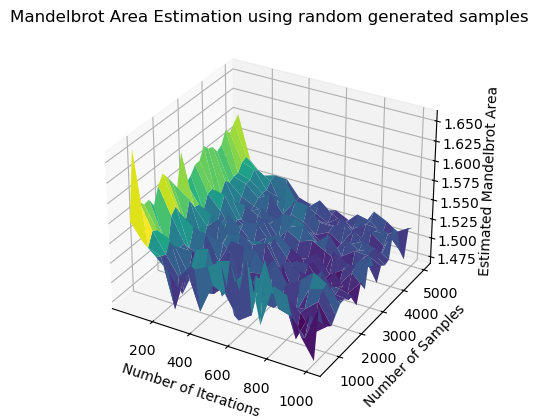

In [171]:
def plot_area_3d(
    areas: np.ndarray[float],
    samples_range: np.ndarray[int],
    iterations_range: np.ndarray[int],
    plot_title: str,
):
    """Plot the calculated areas of the Mandelbrot set as a function of amount of samples and iterations.

    Args:
        areas: The 3D array containing all the areas indexed by the samples and iterations.
        samples_range: The range of samples used to perform the calculations.
        iterations_range: The range of iterations used to perform the calculations.
        plot_title: Title of the plot that will be generated.
    """
    X, Y = np.meshgrid(iterations_range, samples_range)
    # Take the average over all the runs
    Z = np.mean(areas, axis=2)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="viridis")

    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Number of Samples")
    ax.set_zlabel("Estimated Mandelbrot Area")

    plt.title(plot_title)
    plt.show()

print(
    f"The mean area of the Mandelbrot set when calculated with {samples_range_rs[-1]} random samples\n"
    f"when iterated {iterations_range_rs[-1]} times is {np.mean(areas_rs[-1, -1,:])}."
)

plot_title_rs = "Mandelbrot Area Estimation using random generated samples"
plot_area_3d(areas_rs, samples_range_rs, iterations_range_rs, plot_title_rs)

### Latin Hypercube sampling

In [172]:
def lhs_samples(complex_range: ComplexRange, num_sample: int) -> np.ndarray[complex]:
    """Generate Latin Hypercube Sampling (LHS) points in a complex range.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        num_sample: The number of samples to generate.

    Returns:
        An array of complex numbers sampled using the LHS method.
    """

    def lhs_1d(min_val: float, max_val: float, num_sample: int) -> np.ndarray[float]:
        """Generate Latin Hypercube Sampling (LHS) points in one dimension. Essentially, multiple
        bins are created withing the value range. In each of these bins, a single random sample
        is generated.

        Args:
            min_val: The minimum value of the range.
            max_val: The maximum value of the range.
            num_sample: The number of samples to generate.

        Returns:
            An array of points sampled with LHS within the range.
        """
        # Create 'bins' on the [0,1] interval
        intervals = np.linspace(0, 1, num_sample + 1)

        # Compute random samples in each bin
        random_offsets = np.random.uniform(size=num_sample)
        normed_samples = intervals[:-1] + random_offsets / num_sample

        # Scale samples to the target range
        samples = min_val + normed_samples * (max_val - min_val)
        np.random.shuffle(samples)

        return samples

    # Generate LHS points for the real and imaginary parts
    real_values = lhs_1d(complex_range.real_min, complex_range.real_max, num_sample)
    imag_values = lhs_1d(complex_range.imaginary_min, complex_range.imaginary_max, num_sample)

    samples = real_values + 1j * imag_values

    return samples

Generated LHS samples:
[-1.51161548-1.39554235j -0.90030848+0.20866699j  0.79844115+0.78262818j
 -0.39186027+0.94059595j -1.12386096-0.83212657j  0.65168318-0.92121831j
 -1.77977407+1.2485222j   0.28035198+0.58611786j -0.74364141-0.0137925j
 -0.15460112-0.39219924j]


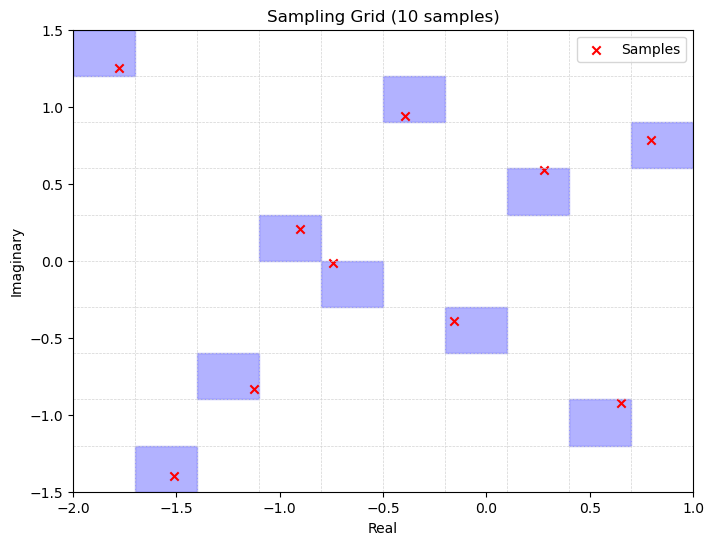

In [173]:
def visualize_samples(complex_range: ComplexRange, samples: np.ndarray[complex]):
    """Visualize samples by marking them and highlighting the box they are part of. Used
    to verify the correctness of LHS and orthogonal sample creation.

    Args:
        complex_range: The range of complex numbers where samples have been drawn from.
        samples: The generated samples to visualize.
    """
    real_values = samples.real
    imag_values = samples.imag

    # Compute the grid boundaries
    real_bounds = np.linspace(complex_range.real_min, complex_range.real_max, samples.shape[0] + 1)
    imag_bounds = np.linspace(
        complex_range.imaginary_min, complex_range.imaginary_max, samples.shape[0] + 1
    )

    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    # Draw grid lines
    for i in range(samples.shape[0] + 1):
        plt.axvline(x=real_bounds[i], color="lightgray", linestyle="--", linewidth=0.5)
        plt.axhline(y=imag_bounds[i], color="lightgray", linestyle="--", linewidth=0.5)

    # Highlight squares containing samples
    for real_value, imag_value in zip(real_values, imag_values):
        # Find the indices of the grid cell containing the sample
        i = np.searchsorted(real_bounds, real_value, side="right") - 1
        j = np.searchsorted(imag_bounds, imag_value, side="right") - 1
        # Create a rectangle patch for the grid cell
        rect = patches.Rectangle(
            (real_bounds[i], imag_bounds[j]),
            real_bounds[i + 1] - real_bounds[i],
            imag_bounds[j + 1] - imag_bounds[j],
            color="blue",
            alpha=0.3,
        )
        ax.add_patch(rect)

    # Plot samples as red crosses
    plt.scatter(real_values, imag_values, color="red", marker="x", label="Samples")
    plt.xlim(complex_range.real_min, complex_range.real_max)
    plt.ylim(complex_range.imaginary_min, complex_range.imaginary_max)
    plt.xlabel("Real")
    plt.ylabel("Imaginary")
    plt.title(f"Sampling Grid ({samples.shape[0]} samples)")
    plt.legend()
    plt.show()


complex_range_lhs = ComplexRange()
visualize_samples_lhs = lhs_samples(complex_range_lhs, 10)

print("Generated LHS samples:")
print(visualize_samples_lhs)

visualize_samples(complex_range_lhs, visualize_samples_lhs)

In [174]:
def mandelbrot_area_LHS(
    complex_range: ComplexRange,
    num_samples: np.ndarray[int],
    num_iterations: np.ndarray[int],
    runs: int = STANDARD_NUM_RUNS,
) -> np.ndarray[float]:
    """Calculates the area of the Mandelbrot set using LHS samples. This function is identical to
    mandelbrot_area_RS besides the sample generation.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        num_samples: The list of number of samples for which an area simulation will be done for.
        num_iterations: The list of number of iterations for which an area simulation will be done for.
        runs: How many times each combination of samples and will be run to get an estimate of the variance.

    Returns:
        A 3D array of area calculations with iterations, samples and runs as indices.
    """
    areas = np.zeros((len(num_samples), len(num_iterations), runs))

    for sample_idx, num_sample in enumerate(tqdm.tqdm(num_samples, desc="Sample Range Progress")):
        for it_idx, num_iteration in enumerate(num_iterations):
            for run in range(runs):
                complex_values = lhs_samples(complex_range, num_sample)

                areas[sample_idx, it_idx, run] = mandelbrot_area(
                    complex_values, num_iteration, complex_range.domain_area
                )

    return areas


samples_range_lhs = np.linspace(
    STANDARD_NUM_SAMPLES_MIN, STANDARD_NUM_SAMPLES_MAX, num=STANDARD_NUM_SAMPLES_STEPS, dtype=int
)
iterations_range_lhs = np.linspace(
    STANDARD_NUM_ITERATIONS_MIN,
    STANDARD_NUM_ITERATIONS_MAX,
    num=STANDARD_NUM_ITERATIONS_STEPS,
    dtype=int,
)

areas_lhs = mandelbrot_area_LHS(ComplexRange(), samples_range_lhs, iterations_range_lhs)

Sample Range Progress: 100%|██████████| 25/25 [01:24<00:00,  3.36s/it]


The mean area of the Mandelbrot set when calculated with 5000 LHS samples
when iterated 1000 times is 1.513872.


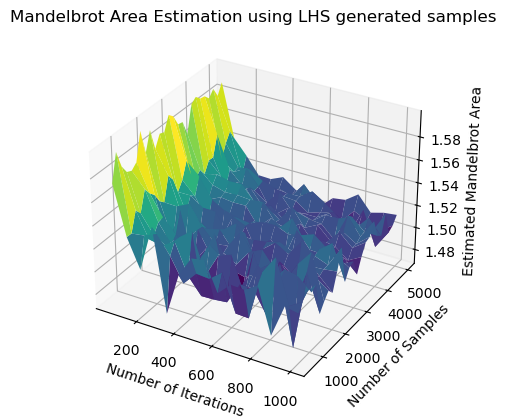

In [175]:
print(
    f"The mean area of the Mandelbrot set when calculated with {samples_range_lhs[-1]} LHS samples\n"
    f"when iterated {iterations_range_lhs[-1]} times is {np.mean(areas_lhs[-1, -1,:])}."
)

plot_title_lhs = "Mandelbrot Area Estimation using LHS generated samples"
plot_area_3d(areas_lhs, samples_range_lhs, iterations_range_lhs, plot_title_lhs)

### Orthogonal Sampling

In [176]:
# This function could still use some refactoring
def orthogonal_samples(complex_range: ComplexRange, grid_size: int) -> np.ndarray[complex]:
    num_samples = grid_size**2
    real_scale = complex_range.real_range_size / num_samples
    imaginary_scale = complex_range.imaginary_range_size / num_samples

    xlist = np.arange(num_samples, dtype=int).reshape(grid_size, grid_size)
    ylist = np.arange(num_samples, dtype=int).reshape(grid_size, grid_size)

    for i in range(grid_size):
        np.random.shuffle(xlist[i])
        np.random.shuffle(ylist[i])

    samples = np.empty((grid_size, grid_size), dtype=np.complex_)
    for i in range(grid_size):
        for j in range(grid_size):
            x = complex_range.real_min + real_scale * (xlist[i][j] + np.random.uniform(0, 1))
            y = complex_range.imaginary_min + imaginary_scale * (
                ylist[j][i] + np.random.uniform(0, 1)
            )
            samples[i, j] = x + 1j * y

    return samples

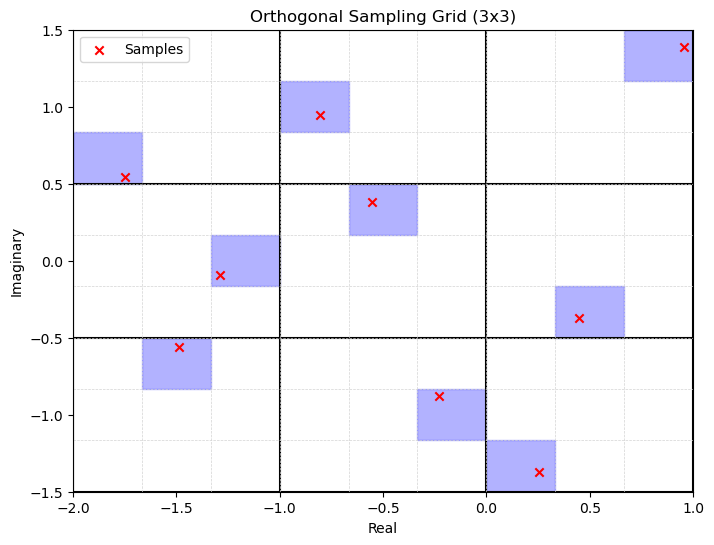

In [177]:
# This function could still use some refactoring
def plot_orthogonal_sampling(complex_range: ComplexRange, grid_size):
    samples = orthogonal_samples(complex_range, grid_size)
    num_samples = grid_size**2

    # Plot the grid and samples
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    real_bounds = np.linspace(complex_range.real_min, complex_range.real_max, grid_size + 1)
    imag_bounds = np.linspace(
        complex_range.imaginary_min, complex_range.imaginary_max, grid_size + 1
    )

    # Add thick black grid lines
    for i in range(grid_size + 1):
        plt.axvline(x=real_bounds[i], color="black", linestyle="-", linewidth=1.5)
        plt.axhline(y=imag_bounds[i], color="black", linestyle="-", linewidth=1.5)

    # Add light gray sub-grid lines
    num_subdivisions = grid_size  # For sub-grid lines
    real_range = np.zeros(num_samples + 1)
    real_range[0] = complex_range.real_min
    real_range[-1] = complex_range.real_max
    imaginary_range = np.zeros(num_samples + 1)
    imaginary_range[0] = complex_range.imaginary_min
    imaginary_range[-1] = complex_range.imaginary_max

    for i in range(grid_size * num_subdivisions + 1):
        real_subdiv = complex_range.real_min + complex_range.real_range_size * i / (grid_size * num_subdivisions)
        imag_subdiv = complex_range.imaginary_min + complex_range.imaginary_range_size * i / (grid_size * num_subdivisions)
        plt.axvline(x=real_subdiv, color="lightgray", linestyle="--", linewidth=0.5)
        plt.axhline(y=imag_subdiv, color="lightgray", linestyle="--", linewidth=0.5)

        if i > 0 or i < num_samples:
            real_range[i] = real_subdiv
            imaginary_range[i] = imag_subdiv

    # Plot samples as crosses
    real_values = samples.real.flatten()
    imag_values = samples.imag.flatten()

    for r, im in zip(real_values, imag_values):
        i = np.searchsorted(real_range, r) - 1
        j = np.searchsorted(imaginary_range, im) - 1
        rect = patches.Rectangle(
            (real_range[i], imaginary_range[j]),
            real_range[i + 1] - real_range[i],
            imaginary_range[j + 1] - imaginary_range[j],
            color="blue",
            alpha=0.3,
        )
        ax.add_patch(rect)

    plt.scatter(real_values, imag_values, color="red", marker="x", label="Samples")

    plt.xlim(complex_range.real_min, complex_range.real_max)
    plt.ylim(complex_range.imaginary_min, complex_range.imaginary_max)
    plt.xlabel("Real")
    plt.ylabel("Imaginary")
    plt.title(f"Orthogonal Sampling Grid ({grid_size}x{grid_size})")
    plt.legend()
    plt.show()


plot_orthogonal_sampling(ComplexRange(), 3)

In [178]:
def mandelbrot_area_ORTH(
    complex_range: ComplexRange,
    grid_sizes: np.ndarray[int],
    num_iterations: np.ndarray[int],
    runs: int = STANDARD_NUM_RUNS,
) -> np.ndarray[float]:
    """Calculates the area of the Mandelbrot set using orthogonal samples. This function is identical to
    mandelbrot_area_RS besides the sample generation and the domain_area used.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        grid_sizes: The list of grid sizes for which an area simulation will be done for.
        num_iterations: The list of number of iterations for which an area simulation will be done for.
        runs: How many times each combination of samples and will be run to get an estimate of the variance.

    Returns:
        A 3D array of area calculations with iterations, samples and runs as indices.
    """
    areas = np.zeros((len(grid_sizes), len(num_iterations), runs))

    for grid_size_idx, grid_size in enumerate(tqdm.tqdm(grid_sizes, desc="Grid Range Progress")):
        for it_idx, num_iteration in enumerate(num_iterations):
            for run in range(runs):
                complex_values = orthogonal_samples(complex_range, grid_size)

                scaled__area = complex_range.domain_area / grid_size

                areas[grid_size_idx, it_idx, run] = mandelbrot_area(
                    complex_values, num_iteration, scaled__area
                )

    return areas

# Square root of default values as the amount of samples is the grid size squared 
grid_sizes_range_orth = np.linspace(
    int(np.sqrt(STANDARD_NUM_SAMPLES_MIN)),
    int(np.sqrt(STANDARD_NUM_SAMPLES_MAX)),
    num=STANDARD_NUM_SAMPLES_STEPS,
    dtype=int,
)
iterations_range_orth = np.linspace(
    STANDARD_NUM_ITERATIONS_MIN,
    STANDARD_NUM_ITERATIONS_MAX,
    num=STANDARD_NUM_ITERATIONS_STEPS,
    dtype=int,
)

areas_orth = mandelbrot_area_ORTH(
    ComplexRange(), grid_sizes_range_orth, iterations_range_orth
)

Grid Range Progress: 100%|██████████| 25/25 [02:18<00:00,  5.55s/it]


The mean area of the Mandelbrot set when calculated with orthogonal samples by generating
70 grids (corresponds to 4900 samples) when iterated 1000 times is 1.509208163265306.


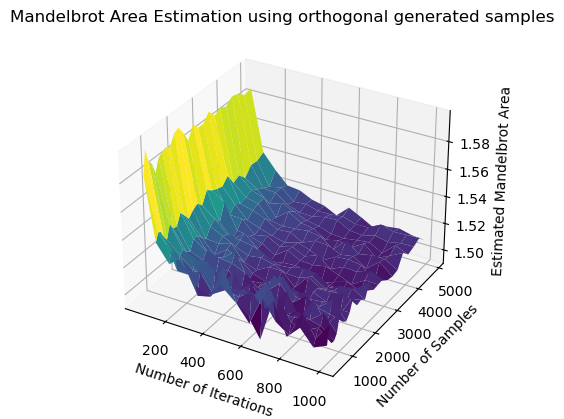

In [179]:
print(
    f"The mean area of the Mandelbrot set when calculated with orthogonal samples "
    f"by generating\n{grid_sizes_range_orth[-1]} grids (corresponds to "
    f"{grid_sizes_range_orth[-1]**2} samples) when iterated {iterations_range_orth[-1]} "
    f"times is {np.mean(areas_orth[-1, -1,:])}."
)

plot_title_orth = "Mandelbrot Area Estimation using orthogonal generated samples"
plot_area_3d(areas_orth, grid_sizes_range_orth**2, iterations_range_orth, plot_title_orth)

The following code can optionally be run to load in the large calculations stored in the .npy files. These variables can be used to recreate the plots we used in the report.

The large simulations were created with 100 runs each. The rest of the parameters can be derived from the code below.

In [121]:
# All these files correspond to the actual simulations we have conducted: 50 to 1000 iterations (50 points),
# 100, 10000 samples (50 points) and 100 runs for each data points.

areas_rs_loaded = np.load("MC.npy")
areas_lhs_loaded = np.load("LHS.npy")
areas_orth_loaded = np.load("Orthogonal.npy")
areas_rs_antithetic_loaded = np.load("Antithetic_MC.npy")

# When we ran the code, we stored it in order: iterations, samples, runs.
# This transposes it to: samples, iterations, runs
areas_rs_loaded = np.transpose(areas_rs_loaded, axes=(1, 0, 2))
areas_lhs_loaded = np.transpose(areas_lhs_loaded, axes=(1, 0, 2))
areas_orth_loaded = np.transpose(areas_orth_loaded, axes=(1, 0, 2))
areas_rs_antithetic_loaded = np.transpose(areas_rs_antithetic_loaded, axes=(1, 0, 2))

samples_range_rs_loaded = np.linspace(100, 10000, num=50, dtype=int)
iterations_range_rs_loaded = np.linspace(50, 1000, num=50, dtype=int)

samples_range_lhs_loaded = np.linspace(100, 10000, num=50, dtype=int)
iterations_range_lhs_loaded = np.linspace(50, 1000, num=50, dtype=int)

grid_sizes_range_orth_loaded = np.linspace(10, 100, num=50, dtype=int)
iterations_range_orth_loaded = np.linspace(50, 1000, num=50, dtype=int)


samples_range_rs_antithetic_loaded = np.linspace(100, 10000, num=50, dtype=int)
iterations_range_rs_antithetic_loaded= np.linspace(50, 1000, num=50, dtype=int)

# Uncomment the following lines to overwrite the data generated in this notebook
# areas_rs = areas_rs_loaded
# areas_lhs = areas_lhs_loaded
# areas_orth = areas_orth_loaded
# areas_rs_antithetic = areas_rs_antithetic_loaded

# samples_range_rs = samples_range_rs_loaded
# iterations_range_rs = iterations_range_rs_loaded

# samples_range_lhs = samples_range_lhs_loaded
# iterations_range_lhs = iterations_range_lhs_loaded

# grid_sizes_range_orth = grid_sizes_range_orth_loaded
# iterations_range_orth = iterations_range_orth_loaded

# samples_range_rs_antithetic = samples_range_rs_antithetic_loaded
# iterations_range_rs_antithetic = iterations_range_rs_antithetic_loaded

### Statistical Analysis of Results

In [180]:
def confidence_interval(
    areas: np.ndarray[float], p_val: float = 0.95, axis: int = 2
) -> tuple[np.ndarray[float]]:
    """Calculate the confidence interval of an area simulation over a given axis.

    Args:
        areas: Array that contains the area calculations.
        p_val: p-value for which the confidence interval will be calculated.
        axis: Axis of the areas array over which the variance will be calculated.

    Returns:
        Tuple containing the arrays of the mean values, lower and upper bounds.
    """
    mean_areas = np.mean(areas, axis=axis)
    area_variances = np.var(areas, axis=axis)

    # Calculate margin of error
    margin = (norm.ppf((p_val + 1) / 2) * np.sqrt(area_variances)) / np.sqrt(areas.shape[axis])

    lower_bound = mean_areas - margin
    upper_bound = mean_areas + margin

    return (mean_areas, lower_bound, upper_bound)

### Analysis plots (Not from data of actual simulations)

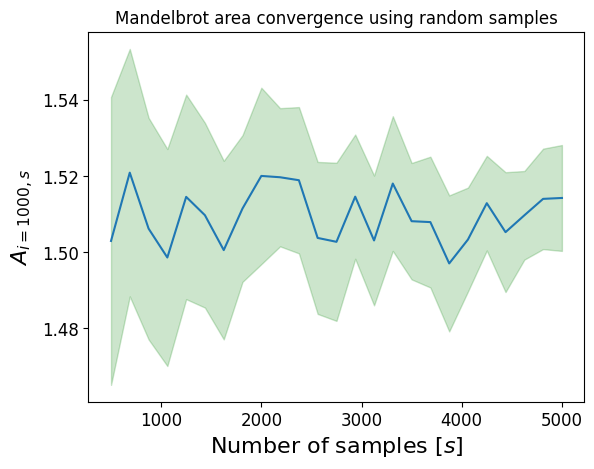

In [117]:
mean_areas_rs, areas_lowerbound_rs, areas_upperbound_rs = confidence_interval(
    areas_rs[:, -1, :], axis=1
)
plt.plot(samples_range_rs, mean_areas_rs)
plt.title("Mandelbrot area convergence using random samples")
plt.xlabel(r"Number of samples $[s]$", fontsize=16)
plt.fill_between(
    samples_range_rs, areas_lowerbound_rs, areas_upperbound_rs, alpha=0.2, color="green"
)
plt.ylabel(r"$A_{i=%i,s}$" % iterations_range_rs[-1], fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

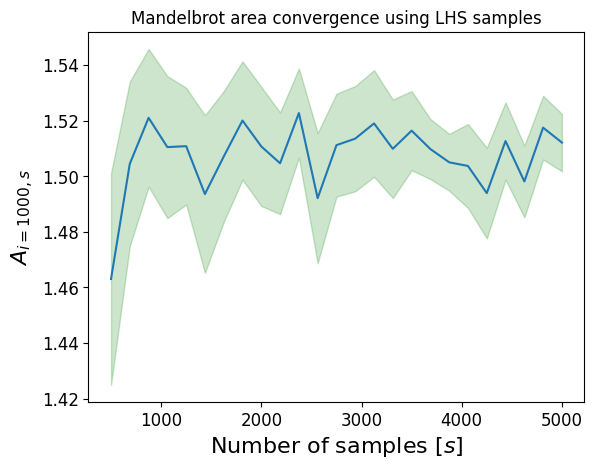

In [120]:
mean_areas_lhs, areas_lowerbound_lhs, areas_upperbound_lhs = confidence_interval(
    areas_lhs[:, -1, :], axis=1
)
plt.title("Mandelbrot area convergence using LHS samples")
plt.plot(samples_range_lhs, mean_areas_lhs)
plt.xlabel(r"Number of samples $[s]$", fontsize=16)
plt.fill_between(
    samples_range_lhs, areas_lowerbound_lhs, areas_upperbound_lhs, alpha=0.2, color="green"
)
plt.ylabel(r"$A_{i=%i,s}$" % iterations_range_lhs[-1], fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

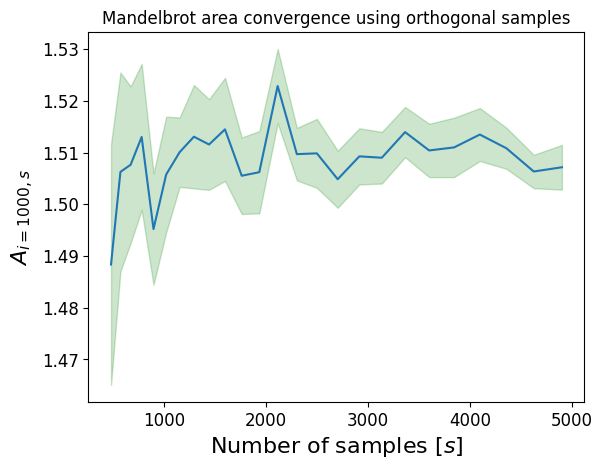

In [119]:
mean_areas_orth, areas_lowerbound_orth, areas_upperbound_orth = confidence_interval(
    areas_orth[:, -1, :], axis=1
)
plt.title("Mandelbrot area convergence using orthogonal samples")
plt.plot(grid_sizes_range_orth**2, mean_areas_orth)
plt.xlabel(r"Number of samples $[s]$", fontsize=16)
plt.fill_between(
    grid_sizes_range_orth**2, areas_lowerbound_orth, areas_upperbound_orth, alpha=0.2, color="green"
)
plt.ylabel(r"$A_{i=%i,s}$" % iterations_range_orth[-1], fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

## Error introduced by amount of iterations

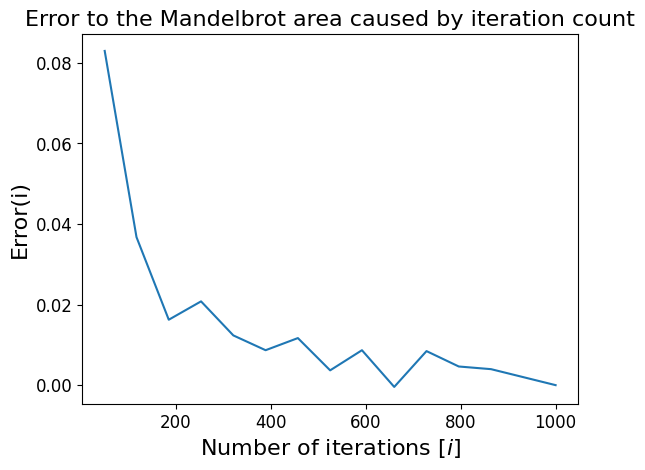

In [115]:
def analyze_iterations_error(areas: np.ndarray[float], num_iterations: np.ndarray[int]):
    """Analyze the error introduced by low iteration count, compared to the
    baseline of a high iteration calculation

    Args:
        areas: Array that contains the area calculations.
    """
    mean_over_runs = np.mean(areas[:, :, :], axis=2)
    highest_sample_size_area = mean_over_runs[-1, :]
    iteration_error = highest_sample_size_area - highest_sample_size_area[-1]
    plt.plot(num_iterations, iteration_error)
    plt.title("Error to the Mandelbrot area caused by iteration count", fontsize=16)
    plt.xlabel("Number of iterations")
    plt.ylabel("Error from iterations count")
    plt.xlabel(r"Number of iterations $[i]$", fontsize=16)
    plt.ylabel(r"Error(i)", fontsize=16)
    plt.tick_params(axis="both", which="major", labelsize=12)
    plt.show()


analyze_iterations_error(areas_orth, iterations_range_orth)

## Reducing variance by using antithetic variables

In [185]:
def mandelbrot_area_RS_antithetic(
    complex_range: ComplexRange,
    num_samples: np.ndarray[int],
    num_iterations: np.ndarray[int],
    runs: int = STANDARD_NUM_RUNS,
) -> np.ndarray[float]:
    """Calculates the area of the Mandelbrot set using Monte Carlo integration. Generates random
    antithetic samples by sampling from two negatively correlated uniform distributions.

    Args:
        complex_range: The range of complex numbers where samples will be drawn from.
        num_samples: The list of number of samples for which an area simulation will be done for.
        num_iterations: The list of number of iterations for which an area simulation will be done for.
        runs: How many times each combination of samples and will be run to get an estimate of the variance.

    Returns:
        A 3D array of area calculations with iterations, samples and runs as indices.
    """
    areas = np.zeros((len(num_samples), len(num_iterations), runs))

    for sample_idx, num_sample in enumerate(tqdm.tqdm(num_samples, desc="Sample Range Progress")):
        for it_idx, num_iteration in enumerate(num_iterations):
            for run in range(runs):
                # Generate random antithetic samples
                u = np.random.uniform(size=num_sample)
                v = np.random.uniform(size=num_sample)
                real_parts = complex_range.real_min + complex_range.real_range_size * u
                imag_parts = complex_range.imaginary_min + complex_range.imaginary_range_size * v
                complex_values = real_parts + 1j * imag_parts
                real_parts_anti = complex_range.real_min + complex_range.real_range_size * (1 - u)
                imag_parts_anti = (
                    complex_range.imaginary_min + complex_range.imaginary_range_size * (1 - v)
                )
                complex_values_anti = real_parts_anti + 1j * imag_parts_anti

                area_original = mandelbrot_area(
                    complex_values, num_iteration, complex_range.domain_area
                )
                area_antithetic = mandelbrot_area(
                    complex_values_anti, num_iteration, complex_range.domain_area
                )

                areas[sample_idx, it_idx, run] = (area_original + area_antithetic) / 2

    return areas


samples_range_rs_antithetic = np.linspace(
    STANDARD_NUM_SAMPLES_MIN, STANDARD_NUM_SAMPLES_MAX, num=STANDARD_NUM_SAMPLES_STEPS, dtype=int
)
iterations_range_rs_antithetic = np.linspace(
    STANDARD_NUM_ITERATIONS_MIN,
    STANDARD_NUM_ITERATIONS_MAX,
    num=STANDARD_NUM_ITERATIONS_STEPS,
    dtype=int,
)

areas_rs_antithetic = mandelbrot_area_RS_antithetic(
    ComplexRange(), samples_range_rs, iterations_range_rs
)

Sample Range Progress: 100%|██████████| 25/25 [02:49<00:00,  6.77s/it]


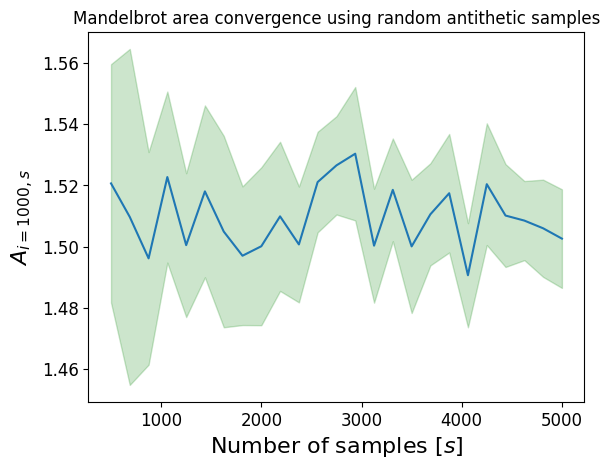

In [123]:
mean_areas_rs_antithetic, areas_lowerbound_rs_antithetic, areas_upperbound_rs_antithetic = (
    confidence_interval(areas_rs_antithetic[:, -1, :], axis=1)
)
plt.title("Mandelbrot area convergence using random antithetic samples")
plt.plot(samples_range_rs_antithetic, mean_areas_rs_antithetic)
plt.xlabel(r"Number of samples $[s]$", fontsize=16)
plt.fill_between(
    samples_range_rs_antithetic,
    areas_lowerbound_rs_antithetic,
    areas_upperbound_rs_antithetic,
    alpha=0.2,
    color="green",
)
plt.ylabel(r"$A_{i=%i,s}$" % iterations_range_rs_antithetic[-1], fontsize=16)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

The following shows the best results we got from all the different sampling methods. These are all found by taking the highest amount of samples and iterations from each dataset.

In [213]:
print("The estimated area (i=1000, s=10000) using random sampling:", np.mean(areas_rs[-1,-1,:]),"+/-" , np.std(areas_rs[-1,-1,:]))
print("With 95 percent confidence interval: ", "[", areas_lowerbound_rs[-1], areas_upperbound_rs[-1], "]")

The estimated area (i=1000, s=10000) using random sampling: 1.5087959999999996 +/- 0.03508922603877149
With 95 percent confidence interval:  [ 1.5019186380718619 1.5156733619281373 ]


In [214]:
print("The estimated area (i=1000, s=10000) using LHS sampling:", np.mean(areas_lhs[-1,-1,:]),"+/-" , np.std(areas_lhs[-1,-1,:]))
print("With 95 percent confidence interval: ", "[", areas_lowerbound_lhs[-1], areas_upperbound_lhs[-1], "]")

The estimated area (i=1000, s=10000) using LHS sampling: 1.5112079999999997 +/- 0.023016883716089804
With 95 percent confidence interval:  [ 1.5066967736880115 1.5157192263119879 ]


In [236]:
print("The estimated area (i=1000, s=10000) using orthogonal sampling:", np.mean(areas_orth[-1,-1,:]),"+/-" , np.std(areas_orth[-1,-1,:]))
print("With 95 percent confidence interval: ", "[", areas_lowerbound_orth[-1], areas_upperbound_orth[-1], "]")

The estimated area (i=1000, s=10000) using orthogonal sampling: 1.5120179999999999 +/- 0.006722921686290858
With 95 percent confidence interval:  [ 1.5107003315623986 1.5133356684376011 ]


In [218]:
print("The estimated area (i=1000, s=10000) using random sampling with antithetic variables:", np.mean(areas_rs_antithetic[-1,-1,:]),"+/-" , np.std(areas_rs_antithetic[-1,-1,:]))
print("With 95 percent confidence interval: ", "[", areas_lowerbound_rs_antithetic[-1], areas_upperbound_rs_antithetic[-1], "]")

The estimated area (i=1000, s=10000) using random sampling with antithetic variables: 1.5041924999999998 +/- 0.030384323569070944
With 95 percent confidence interval:  [ 1.4982372820110008 1.5101477179889988 ]
